# 1. Extracción de datos

In [1]:
# ============================================
# PARTE 0 · Configuración general
# ============================================
import os, time, math, random, itertools, logging
from typing import List, Dict, Any, Tuple, Optional
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from dateutil.parser import isoparse

API_KEY = ("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

# Parámetros principales
TARGET_PLACES_PER_CITY = 200
SEARCH_RADIUS_METERS = 3000        # radio por celda 
OVERLAP_RATIO = 0.25               # solapar para no dejar huecos
MAX_PAGES_PER_QUERY = 3            # cada Nearby/Text Search permite 3 páginas (≈60)
REQUEST_TIMEOUT = 30
SLEEP_BETWEEN_PAGES = 2.0          
RETRY_COUNT = 5
BACKOFF_BASE = 1.6

# Tipos / keywords para barrer más resultados (ajustable)
SEARCH_TYPES = ["lodging", "tourist_attraction", "restaurant", "bar", "cafe",
                "museum","park", "campground","airport","amusement_park"]
KEYWORDS = ["posada", "hotel", "eco lodge", "alojamiento", "hostal","resort", "apartamento turístico", 
            "airbnb", "cabaña", "villa"]  # opcional
RANK_PREFS = ["POPULARITY", "DISTANCE"]  #  rankPreference

# Idiomas para detalles/reseñas (usa ISO, ej. "es", "en", "pt", "fr", "de", ...)
LANGUAGES_FOR_REVIEWS = [
    "es",  # Español (idioma local, mayoría de reseñas en Venezuela y LatAm)
    "en",  # Inglés (turistas internacionales, reseñas globales)
    "pt",  # Portugués (turistas de Brasil y portugal)
    "fr",  # Francés (turistas de Francia y Canadá)
    "de",  # Alemán (turistas europeos frecuentes en ecoturismo)
    "it",  # Italiano (mercado relevante en turismo cultural y aventura)
    "nl"   # Neerlandés (Países Bajos, uno de tus mercados meta futuros)
]

# Logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(message)s")


In [2]:
# ============================================
# PARTE 1 · Utilidades HTTP + reintentos
# ============================================
def _request_with_retry(method: str, url: str, *,
                        headers: Dict[str, str],
                        json: Optional[Dict[str, Any]] = None,
                        params: Optional[Dict[str,str]] = None) -> Dict[str, Any]:
    """Wrapper con reintentos exponenciales y manejo básico de cuotas/429."""
    for attempt in range(1, RETRY_COUNT + 1):
        try:
            resp = requests.request(method, url, headers=headers, json=json, params=params, timeout=REQUEST_TIMEOUT)
            if resp.status_code == 200:
                return resp.json()
            # Manejo suave de 429/5xx
            if resp.status_code in (429, 500, 502, 503, 504):
                sleep_s = (BACKOFF_BASE ** attempt) + random.uniform(0, 0.777)
                logging.warning(f"HTTP {resp.status_code}; reintento {attempt}/{RETRY_COUNT} en {sleep_s:.1f}s")
                time.sleep(sleep_s)
                continue
            # Otros errores => levantar
            resp.raise_for_status()
        except requests.RequestException as e:
            if attempt == RETRY_COUNT:
                raise
            sleep_s = (BACKOFF_BASE ** attempt) + random.uniform(0, 0.5)
            logging.warning(f"Error {e}; reintento {attempt}/{RETRY_COUNT} en {sleep_s:.1f}s")
            time.sleep(sleep_s)
    return {}


In [3]:
# ============================================
# PARTE 2 · Localizar la ciudad (viewport) con Text Search
# ============================================
def get_city_viewport(city_query: str) -> Tuple[Tuple[float,float], Tuple[float,float]]:
    """
    Usa Places Text Search para la consulta de ciudad (p.ej. "Caracas, Venezuela")
    y devuelve ((lat_min, lng_min), (lat_max, lng_max)) del viewport.
    """
    url = "https://places.googleapis.com/v1/places:searchText"
    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": API_KEY,
        # Campo mínimo para recuperar viewport + nombre
        "X-Goog-FieldMask": (
            "places.displayName,places.id,places.location,places.viewport"
        )
    }
    body = {"textQuery": city_query}
    data = _request_with_retry("POST", url, headers=headers, json=body)
    places = data.get("places", [])
    if not places:
        raise ValueError(f"No se encontró viewport para: {city_query}")

    vp = places[0].get("viewport", {})
    # Estructura: viewport.low (lat/lng), viewport.high (lat/lng)
    low = vp.get("low", {})
    high = vp.get("high", {})
    lat_min, lng_min = low.get("latitude"), low.get("longitude")
    lat_max, lng_max = high.get("latitude"), high.get("longitude")
    if None in (lat_min, lng_min, lat_max, lng_max):
        # fallback: usar un pequeño bbox alrededor de location
        loc = places[0].get("location", {})
        clat, clng = loc.get("latitude"), loc.get("longitude")
        if clat is None or clng is None:
            raise ValueError(f"Sin viewport ni location para: {city_query}")
        # ~10km bbox
        dlat = 0.09
        dlng = 0.09
        lat_min, lat_max = clat - dlat, clat + dlat
        lng_min, lng_max = clng - dlng, clng + dlng

    return (lat_min, lng_min), (lat_max, lng_max)


In [4]:
# ============================================
# PARTE 3 · Crear un grid de celdas dentro del viewport
# ============================================
def grid_from_viewport(vp_low: Tuple[float,float], vp_high: Tuple[float,float],
                       radius_m: int, overlap_ratio: float) -> List[Tuple[float,float]]:
    """
    Divide el viewport en centros separados por ~2*radius (con solape).
    Aproximación: convertimos ~metros a grados usando factores promedio.
    """
    lat_min, lng_min = vp_low
    lat_max, lng_max = vp_high

    # Aprox: 1° lat ~ 111.3 km; 1° lng ~ 111.3 km * cos(lat)
    # Tomamos lat media del viewport para el cálculo del paso en lng.
    lat_mid = (lat_min + lat_max) / 2.0
    meters_per_deg_lat = 111_300.0
    meters_per_deg_lng = meters_per_deg_lat * math.cos(math.radians(lat_mid))

    step_deg_lat = (2 * radius_m) / meters_per_deg_lat
    step_deg_lng = (2 * radius_m) / meters_per_deg_lng

    # Solapar
    step_deg_lat *= (1 - overlap_ratio)
    step_deg_lng *= (1 - overlap_ratio)

    lats = []
    lat = lat_min + (radius_m / meters_per_deg_lat)
    while lat <= (lat_max - radius_m / meters_per_deg_lat):
        lats.append(lat)
        lat += step_deg_lat

    lngs = []
    lng = lng_min + (radius_m / meters_per_deg_lng)
    while lng <= (lng_max - radius_m / meters_per_deg_lng):
        lngs.append(lng)
        lng += step_deg_lng

    centers = list(itertools.product(lats, lngs))
    if not centers:
        # fallback a un único centro en el medio
        centers = [((lat_min + lat_max)/2, (lng_min + lng_max)/2)]
    return centers


In [5]:
# ============================================
# PARTE 4 · Nearby Search paginado por celda
# ============================================
def nearby_search_cell(center: Tuple[float,float],
                       type_: Optional[str] = None,
                       rank_preference: str = "POPULARITY",
                       max_result_count: int = 20) -> List[Dict[str, Any]]:
    """
    Ejecuta Places Nearby (v1). No admite 'keyword'.
    Usa maxResultCount (1–20). Para + resultados, barrer más celdas/combos.
    Docs: https://developers.google.com/maps/documentation/places/web-service/reference/rest/v1/places/searchNearby
    """
    url = "https://places.googleapis.com/v1/places:searchNearby"
    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": API_KEY,
        "X-Goog-FieldMask": (
            "places.id,places.displayName,places.formattedAddress,places.location,"
            "places.types,places.rating,places.userRatingCount,places.nationalPhoneNumber,"
            "places.websiteUri"
        )
    }

    body = {
        "locationRestriction": {
            "circle": {
                "center": {"latitude": center[0], "longitude": center[1]},
                "radius": SEARCH_RADIUS_METERS
            }
        },
        "rankPreference": rank_preference,
        "maxResultCount": max_result_count
    }
    if type_:
        # Se puede usar includedPrimaryTypes o includedTypes (Tabla A)
        body["includedPrimaryTypes"] = [type_]

    data = _request_with_retry("POST", url, headers=headers, json=body)
    return data.get("places", [])

In [6]:
# ============================================
# PARTE 5 · Cosecha de ubicaciones por ciudad (grid + combinaciones)
# ============================================
def harvest_places_for_city(city: str) -> pd.DataFrame:
    (low, high) = get_city_viewport(city)
    centers = grid_from_viewport(low, high, SEARCH_RADIUS_METERS, OVERLAP_RATIO)

    seen = {}
    for (lat, lng) in tqdm(centers, desc=f"Grid {city}"):
        for type_ in SEARCH_TYPES:
            for rank in RANK_PREFS:
                places = nearby_search_cell((lat, lng), type_=type_, rank_preference=rank, max_result_count=20)
                for p in places:
                    seen[p["id"]] = p
        if len(seen) >= TARGET_PLACES_PER_CITY:
            break

    rows = []
    for pid, p in seen.items():
        name = (p.get("displayName") or {}).get("text")
        addr = p.get("formattedAddress")
        loc = p.get("location") or {}
        rows.append({
            "place_id": pid,
            "name": name,
            "address": addr,
            "lat": loc.get("latitude"),
            "lng": loc.get("longitude"),
            "types": ",".join(p.get("types", [])),
            "rating": p.get("rating"),
            "user_rating_count": p.get("userRatingCount"),
            "phone": p.get("nationalPhoneNumber"),
            "website": p.get("websiteUri"),
            "city_query": city
        })

    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(by=["user_rating_count", "rating"], ascending=[False, False]).head(TARGET_PLACES_PER_CITY)
    return df


In [7]:

# ============================================
# PARTE 6 · Detalles y Reseñas (multi-idioma con languageCode)
# ============================================
def get_place_details(place_id: str, language: str = "es") -> Dict[str, Any]:
    """
    Place Details con field mask para reseñas y metadatos clave.
    languageCode controla la localización (y potencial traducción, si disponible).
    """
    url = f"https://places.googleapis.com/v1/places/{place_id}"
    headers = {
        "X-Goog-Api-Key": API_KEY,
        "X-Goog-FieldMask": (
            "id,displayName,formattedAddress,location,types,rating,userRatingCount,"
            "nationalPhoneNumber,websiteUri,"
            "reviews.rating,reviews.publishTime,"
            "reviews.text,reviews.originalText,"
            "reviews.authorAttribution"
        ),
        "Accept": "application/json"
    }
    params = {"languageCode": language}
    data = _request_with_retry("GET", url, headers=headers, params=params)
    return data


def flatten_reviews(place: Dict[str, Any], language: str) -> List[Dict[str, Any]]:
    """Convierte el bloque de reviews en filas planas."""
    reviews = place.get("reviews", []) or []
    out = []
    for rv in reviews:
        text = (rv.get("text") or {}).get("text")
        # Algunas respuestas incluyen originalText además de text (p.ej. traducción)
        original_text = (rv.get("originalText") or {}).get("text")
        author = rv.get("authorAttribution", {}) or {}
        author_name = author.get("displayName")
        author_uri = author.get("uri")
        rating = rv.get("rating")
        ts = rv.get("publishTime")
        try:
            ts_parsed = isoparse(ts).isoformat()
        except Exception:
            ts_parsed = ts

        out.append({
            "place_id": place.get("id"),
            "place_name": (place.get("displayName") or {}).get("text"),
            "place_address": place.get("formattedAddress"),
            "review_language_requested": language,
            "review_text": text,
            "review_original_text": original_text,
            "review_rating": rating,
            "review_time": ts_parsed,
            "author_name": author_name,
            "author_uri": author_uri
        })
    return out


def collect_reviews_for_places(df_places: pd.DataFrame,
                               languages: List[str]) -> pd.DataFrame:
    """
    Para cada lugar, pide detalles en varios idiomas y acumula reseñas.
    """
    all_rows = []
    for _, row in tqdm(df_places.iterrows(), total=len(df_places), desc="Detalles+Reseñas"):
        pid = row["place_id"]
        for lang in languages:
            place = get_place_details(pid, language=lang)
            rows = flatten_reviews(place, language=lang)
            all_rows.extend(rows)
            # Respeta cuotas
            time.sleep(0.2)
    reviews_df = pd.DataFrame(all_rows)
    return reviews_df

In [8]:
# ============================================
# PARTE 7 · Pipeline por ciudades y guardado
# ============================================
def run_pipeline(cities: List[str], out_prefix: str = "places"):
    all_places = []
    all_reviews = []

    for city in cities:
        logging.info(f"==> Ciudad: {city}")
        df_city = harvest_places_for_city(city)
        if df_city.empty:
            logging.warning(f"Sin resultados para {city}")
            continue

        # Guardado intermedio
        path_places = f"{out_prefix}_places_{city.replace(',', '').replace(' ', '_')}.csv"
        df_city.to_csv(path_places, index=False)
        logging.info(f"Guardado places ({len(df_city)}): {path_places}")
        all_places.append(df_city)

        # Reseñas multi-idioma
        df_reviews = collect_reviews_for_places(df_city, LANGUAGES_FOR_REVIEWS)
        path_reviews = f"{out_prefix}_reviews_{city.replace(',', '').replace(' ', '_')}.csv"
        df_reviews.to_csv(path_reviews, index=False)
        logging.info(f"Guardado reviews ({len(df_reviews)}): {path_reviews}")
        all_reviews.append(df_reviews)

    if all_places:
        places_all = pd.concat(all_places, ignore_index=True)
        places_all.to_csv(f"{out_prefix}_places_ALL.csv", index=False)
    if all_reviews:
        reviews_all = pd.concat(all_reviews, ignore_index=True)
        reviews_all.to_csv(f"{out_prefix}_reviews_ALL.csv", index=False)

In [9]:
# ============================================
# PARTE 8 · Ejemplo de ejecución
# ============================================
if __name__ == "__main__":
    CITIES = [
        "Caracas, Venezuela",
        "Porlamar, Nueva Esparta, Venezuela",
        "Los Roques, Venezuela",
        "Choroní, Venezuela",
        "Morrocoy, Venezuela",
        "Higuerote, Venezuela",
        "Canaima, Venezuela"
    ]
    run_pipeline(CITIES, out_prefix="guacamaia")

INFO:==> Ciudad: Caracas, Venezuela
Grid Caracas, Venezuela:   8%|▊         | 2/24 [00:27<04:57, 13.50s/it]
INFO:Guardado places (200): guacamaia_places_Caracas_Venezuela.csv
Detalles+Reseñas: 100%|██████████| 200/200 [14:16<00:00,  4.28s/it]
INFO:Guardado reviews (3124): guacamaia_reviews_Caracas_Venezuela.csv
INFO:==> Ciudad: Porlamar, Nueva Esparta, Venezuela
Grid Porlamar, Nueva Esparta, Venezuela: 100%|██████████| 2/2 [00:14<00:00,  7.23s/it]
INFO:Guardado places (91): guacamaia_places_Porlamar_Nueva_Esparta_Venezuela.csv
Detalles+Reseñas: 100%|██████████| 91/91 [06:41<00:00,  4.41s/it]
INFO:Guardado reviews (1491): guacamaia_reviews_Porlamar_Nueva_Esparta_Venezuela.csv
INFO:==> Ciudad: Los Roques, Venezuela
Grid Los Roques, Venezuela: 100%|██████████| 99/99 [12:35<00:00,  7.64s/it]
INFO:Guardado places (91): guacamaia_places_Los_Roques_Venezuela.csv
Detalles+Reseñas: 100%|██████████| 91/91 [06:23<00:00,  4.21s/it]
INFO:Guardado reviews (2254): guacamaia_reviews_Los_Roques_Venezue

# 2. Fase 2: Exploratory Data Analysis (EDA)

In [10]:
## 2.1 Carga y primera visualización

In [11]:
# ============================================
# FASE 2 – EXPLORATORY DATA ANALYSIS (EDA)
# ============================================

# --- PARTE 0 · Librerías y configuración

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

In [12]:
# --- PARTE 1 · Cargar datasets
places = pd.read_csv("guacamaia_places_ALL.csv")
reviews = pd.read_csv("guacamaia_reviews_ALL.csv")

print("Lugares:", places.shape)
print("Reseñas:", reviews.shape)

display(places.head())
display(reviews.head())

Lugares: (829, 11)
Reseñas: (16473, 10)


,place_id,name,address,lat,lng,types,rating,user_rating_count,phone,website,city_query
0,ChIJ_6IhY5X1KowR1rdSkMEk7NY,Hotel Bosque Dorado,"9 Carr. Panamericana, Caracas 1204, Miranda, V...",10.409503,-66.959532,"hotel,lodging,point_of_interest,establishment",4.7,340.0,0212-6727734,https://hotelbosquedorado.com/,"Caracas, Venezuela"
1,ChIJ09LUq3_1KowRE17ncw88Gl8,Boulevard de Caricuao,"C2MG+83X, Av. Principal de Caricuao, Caracas 1...",10.433364,-66.974773,"park,point_of_interest,establishment",4.3,319.0,NaN,NaN,"Caracas, Venezuela"
2,ChIJ5RWJmb_1KowR25jH9spP6TQ,Alejandro Otero Museum,"Museo Alejandro Otero, Caracas 1090, Distrito ...",10.433588,-66.928297,"museum,tourist_attraction,point_of_interest,es...",4.3,319.0,0416-8161554,NaN,"Caracas, Venezuela"
3,ChIJiVm1fPX0KowRo3tAc184GqA,Restaurante El Faro,"1204, 92WX+XFG, San Antonio de Los Altos 1204,...",10.397569,-66.951332,"restaurant,food,point_of_interest,establishment",4.3,212.0,0412-3169385,NaN,"Caracas, Venezuela"
4,ChIJyRXoLjj1KowRSOn6WT8jVJU,Cochinera Caricuao,"C2Q7+5CF, Caracas 1000, Capital District, Vene...",10.437932,-66.986461,"bar,point_of_interest,establishment",4.1,202.0,NaN,NaN,"Caracas, Venezuela"


,place_id,place_name,place_address,review_language_requested,review_text,review_original_text,review_rating,review_time,author_name,author_uri
0,ChIJ_6IhY5X1KowR1rdSkMEk7NY,Hotel Bosque Dorado,"9 Carr. Panamericana, Caracas 1204, Miranda, V...",es,El hotel es recomendable para pasar la noche ...,El hotel es recomendable para pasar la noche ...,4,2025-06-16T13:56:59.255842+00:00,Natlily,https://www.google.com/maps/contrib/1052000324...
1,ChIJ_6IhY5X1KowR1rdSkMEk7NY,Hotel Bosque Dorado,"9 Carr. Panamericana, Caracas 1204, Miranda, V...",es,Exelente servicio muy bueno me encanto,Exelente servicio muy bueno me encanto,4,2025-04-15T00:23:30.065237+00:00,anjerlin del valle,https://www.google.com/maps/contrib/1127290373...
2,ChIJ_6IhY5X1KowR1rdSkMEk7NY,Hotel Bosque Dorado,"9 Carr. Panamericana, Caracas 1204, Miranda, V...",es,Excelente paisaje y muy buen servicio\nEs un s...,Excelente paisaje y muy buen servicio\nEs un s...,5,2024-10-31T15:09:49.876310+00:00,Jobcabeth Sanchez,https://www.google.com/maps/contrib/1042933719...
3,ChIJ_6IhY5X1KowR1rdSkMEk7NY,Hotel Bosque Dorado,"9 Carr. Panamericana, Caracas 1204, Miranda, V...",es,Excelente hotel hubo un momento que pasamos po...,Excelente hotel hubo un momento que pasamos po...,5,2024-07-21T23:22:15.511224+00:00,Frank Pesce,https://www.google.com/maps/contrib/1166637295...
4,ChIJ_6IhY5X1KowR1rdSkMEk7NY,Hotel Bosque Dorado,"9 Carr. Panamericana, Caracas 1204, Miranda, V...",es,Gratamente sorprendido por el estado de las i...,Gratamente sorprendido por el estado de las i...,4,2023-07-28T13:43:40.376775+00:00,daniel marrero garcia,https://www.google.com/maps/contrib/1135300301...


## 2.2 Calidad y estructura de los datos

In [13]:
# Info general
print(places.info())
print(reviews.info())

# Valores nulos
print("Nulos en places:\n", places.isna().sum())
print("Nulos en reviews:\n", reviews.isna().sum())

# Duplicados
print("Duplicados en places:", places.duplicated("place_id").sum())
print("Duplicados en reviews:", reviews.duplicated().sum())# Info general
print(places.info())
print(reviews.info())

# Valores nulos
print("Nulos en places:\n", places.isna().sum())
print("Nulos en reviews:\n", reviews.isna().sum())

# Duplicados
print("Duplicados en places:", places.duplicated("place_id").sum())
print("Duplicados en reviews:", reviews.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   place_id           829 non-null    object 
 1   name               829 non-null    object 
 2   address            829 non-null    object 
 3   lat                829 non-null    float64
 4   lng                829 non-null    float64
 5   types              829 non-null    object 
 6   rating             614 non-null    float64
 7   user_rating_count  614 non-null    float64
 8   phone              383 non-null    object 
 9   website            110 non-null    object 
 10  city_query         829 non-null    object 
dtypes: float64(4), object(7)
memory usage: 71.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16473 entries, 0 to 16472
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  -

In [14]:
## 2.3 Geografía y oferta turística

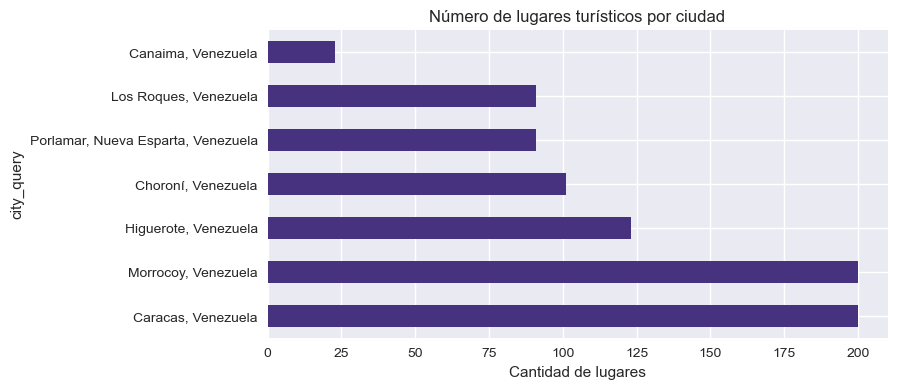

In [15]:
# Lugares por ciudad
places_per_city = places["city_query"].value_counts()
places_per_city.plot(kind="barh", figsize=(8,4))
plt.title("Número de lugares turísticos por ciudad")
plt.xlabel("Cantidad de lugares")
plt.show()



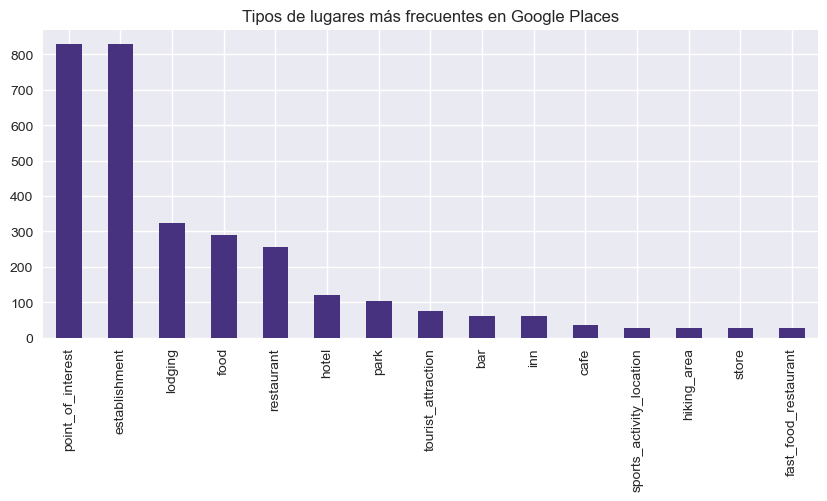

In [16]:
# Tipos de lugares más frecuentes
from collections import Counter
all_types = ",".join(places["types"].dropna())
type_counts = Counter(all_types.split(","))
pd.Series(type_counts).sort_values(ascending=False).head(15).plot(kind="bar", figsize=(10,4))
plt.title("Tipos de lugares más frecuentes en Google Places")
plt.show()

In [17]:
## 2.4 Análisis de reseñas

INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


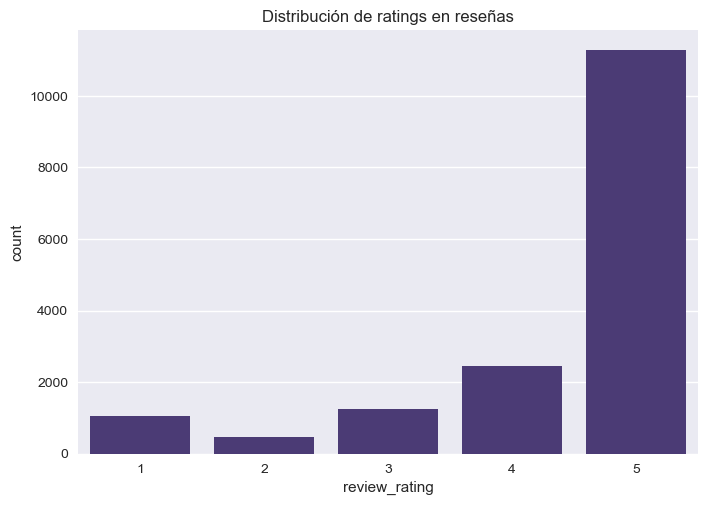

In [18]:
# Distribución de ratings
sns.countplot(x="review_rating", data=reviews)
plt.title("Distribución de ratings en reseñas")
plt.show()

In [19]:
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0  # reproducibilidad

# --- Detectar idioma real
def detect_lang_safe(x):
    try:
        return detect(x) if isinstance(x, str) and len(x) > 3 else "unk"
    except:
        return "unk"

reviews["lang_detected"] = reviews["review_text"].apply(detect_lang_safe)


C:\Users\Jose Ruiz\AppData\Local\Temp\ipykernel_25500\2384421721.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Idioma", y="Cantidad", data=lang_counts, palette="viridis")


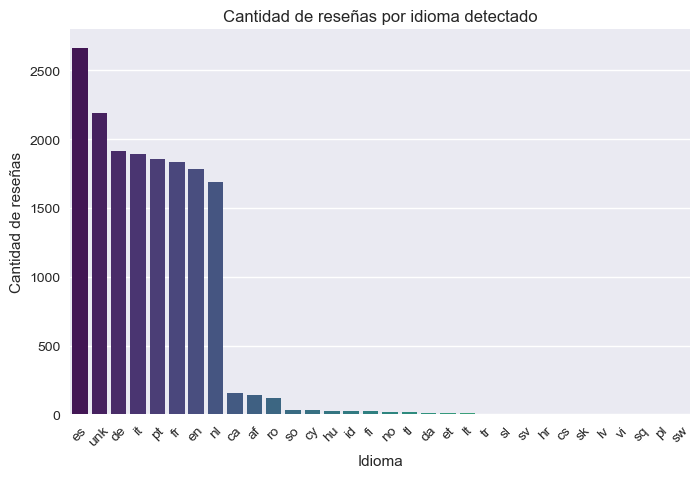

In [20]:
lang_counts = reviews["lang_detected"].value_counts().reset_index()
lang_counts.columns = ["Idioma", "Cantidad"]
lang_counts["Porcentaje"] = 100 * lang_counts["Cantidad"] / lang_counts["Cantidad"].sum()

plt.figure(figsize=(8,5))
sns.barplot(x="Idioma", y="Cantidad", data=lang_counts, palette="viridis")
plt.title("Cantidad de reseñas por idioma detectado")
plt.xlabel("Idioma")
plt.ylabel("Cantidad de reseñas")
plt.xticks(rotation=45)
plt.show()

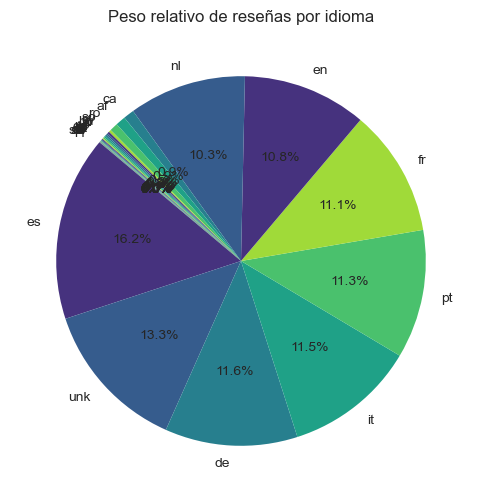

In [21]:
# --- Pie chart
plt.figure(figsize=(6,6))
plt.pie(lang_counts["Porcentaje"], labels=lang_counts["Idioma"], autopct='%1.1f%%', startangle=140)
plt.title("Peso relativo de reseñas por idioma")
plt.show()

In [22]:
# --- Merge: añadir city_query a las reseñas
reviews = reviews.merge(
    places[["place_id","city_query"]],
    on="place_id",
    how="left"
)

# --- Agrupar por ciudad e idioma
city_lang = reviews.groupby(["city_query","lang_detected"]).size().reset_index(name="count")

# Pivotar para stacked barplot
pivot_lang = city_lang.pivot(index="city_query", columns="lang_detected", values="count").fillna(0)

# --- Seleccionar solo los 10 idiomas con más reseñas globales
top10_langs = reviews["lang_detected"].value_counts().head(10).index
pivot_lang = pivot_lang[top10_langs.intersection(pivot_lang.columns)]

# Normalizar a porcentajes
pivot_lang_pct = pivot_lang.div(pivot_lang.sum(axis=1), axis=0) * 100

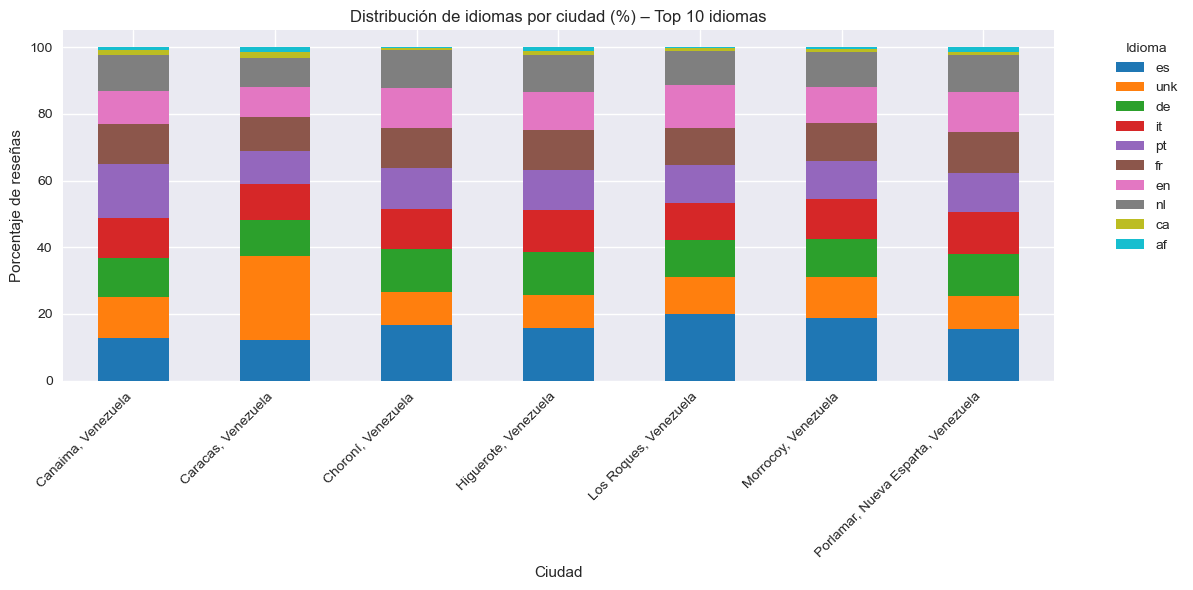

In [23]:
# --- Graficar
pivot_lang_pct.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab10")
plt.title("Distribución de idiomas por ciudad (%) – Top 10 idiomas")
plt.ylabel("Porcentaje de reseñas")
plt.xlabel("Ciudad")
plt.legend(title="Idioma", bbox_to_anchor=(1.05,1), loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

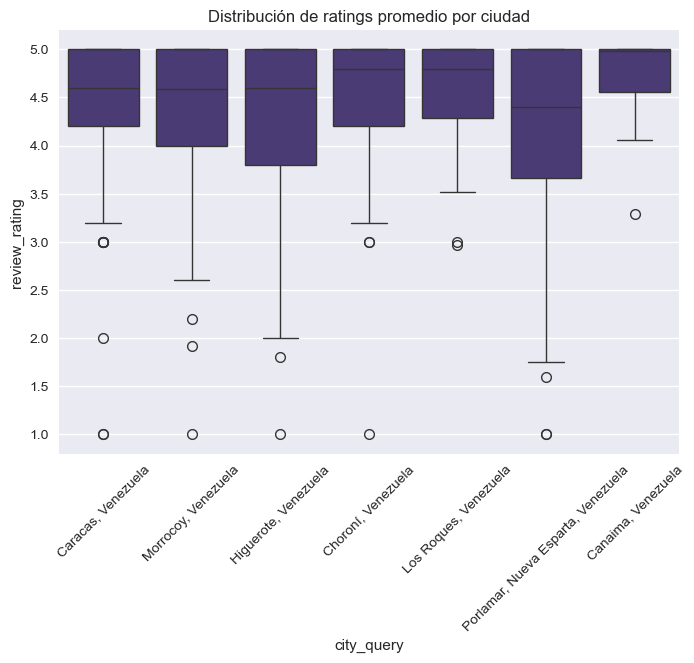

In [24]:
# Ratings promedio por ciudad
city_rating = reviews.groupby("place_id")["review_rating"].mean().reset_index()
city_rating = city_rating.merge(places[["place_id","city_query"]], on="place_id", how="left")

sns.boxplot(x="city_query", y="review_rating", data=city_rating)
plt.title("Distribución de ratings promedio por ciudad")
plt.xticks(rotation=45)
plt.show()


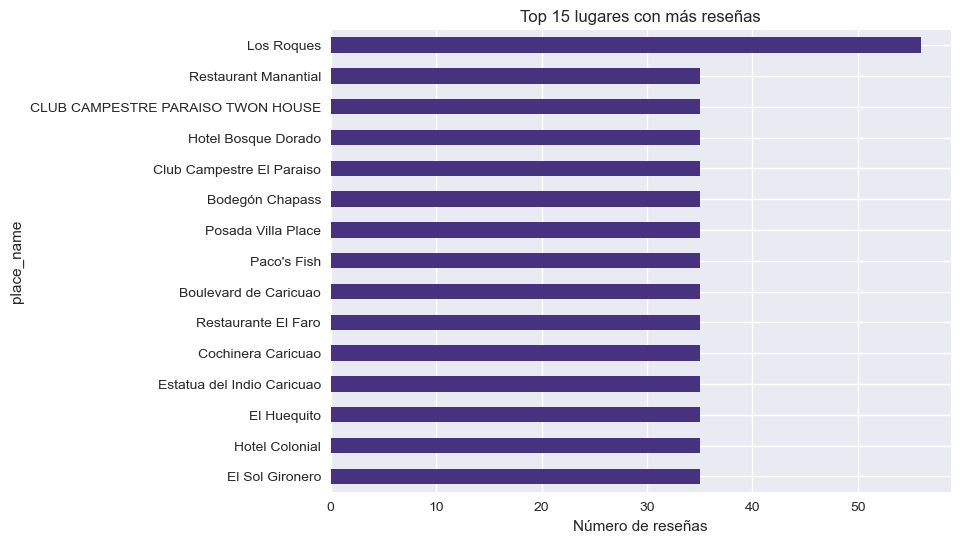

In [25]:
# Top 15 lugares más reseñados
top_places = reviews["place_name"].value_counts().head(15)
top_places.plot(kind="barh", figsize=(8,6))
plt.title("Top 15 lugares con más reseñas")
plt.xlabel("Número de reseñas")
plt.gca().invert_yaxis()
plt.show()

In [26]:
output_file = "guacamaia_reviews_export.csv"
reviews.to_csv(output_file, index=False, encoding="utf-8-sig")

In [27]:
## 2.5 Temporalidad

C:\Users\Jose Ruiz\AppData\Local\Temp\ipykernel_25500\1984633432.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  reviews.set_index("review_time").resample("M").size().plot(figsize=(12,4))


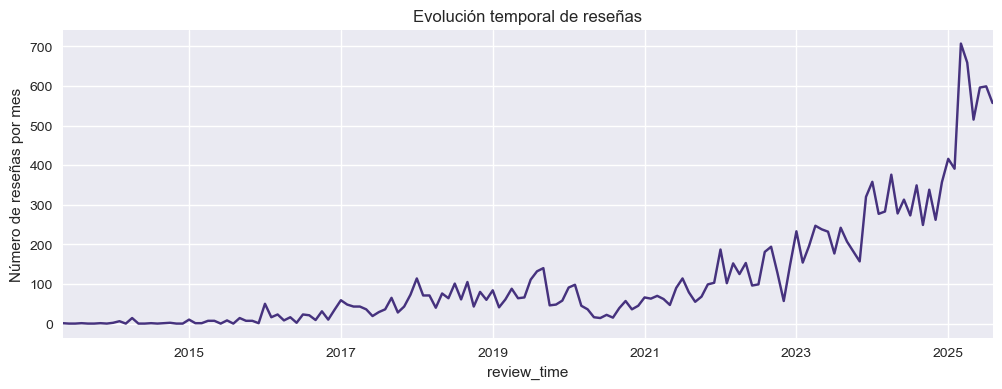

In [28]:
# Convertir fechas
reviews["review_time"] = pd.to_datetime(reviews["review_time"], errors="coerce")

# Reseñas por mes
reviews.set_index("review_time").resample("M").size().plot(figsize=(12,4))
plt.title("Evolución temporal de reseñas")
plt.ylabel("Número de reseñas por mes")
plt.show()

In [29]:
## 2.6 Relación reseñas - rating

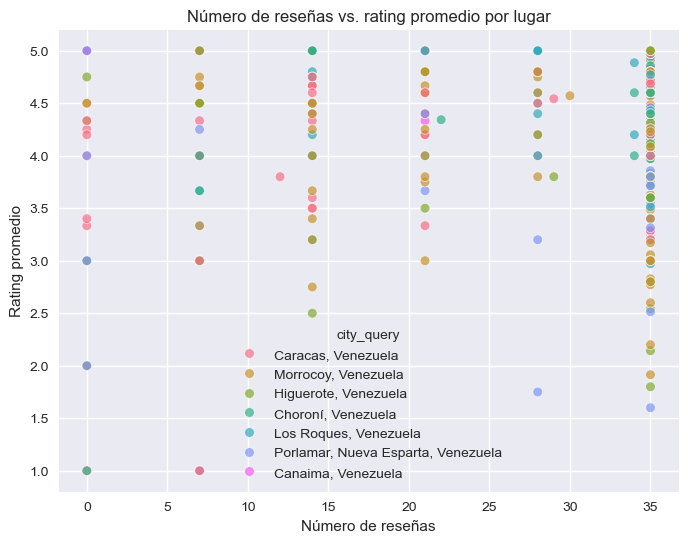

In [30]:
review_stats = reviews.groupby("place_id").agg(
    n_reviews=("review_text","count"),
    avg_rating=("review_rating","mean")
).reset_index()

review_stats = review_stats.merge(
    places[["place_id","name","city_query"]],
    on="place_id"
)

plt.figure(figsize=(8,6))
sns.scatterplot(x="n_reviews", y="avg_rating", hue="city_query", data=review_stats, alpha=0.7)
plt.title("Número de reseñas vs. rating promedio por lugar")
plt.xlabel("Número de reseñas")
plt.ylabel("Rating promedio")
plt.show()

In [31]:
## 2.7 WordCloud por ciudad (visión inicial de NLP)

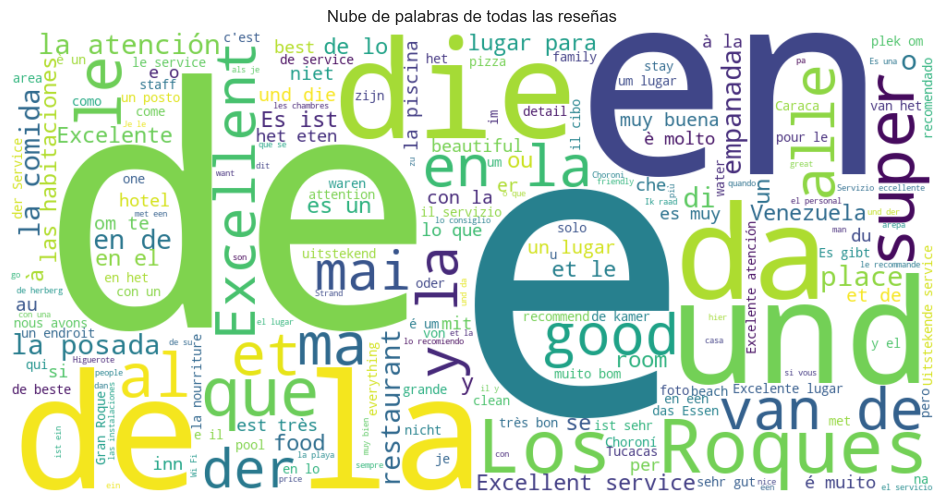

In [32]:
text = " ".join(reviews["review_text"].dropna().astype(str).tolist())
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de todas las reseñas")
plt.show()

In [33]:
# --- PARTE 6 · Lugares más reseñados


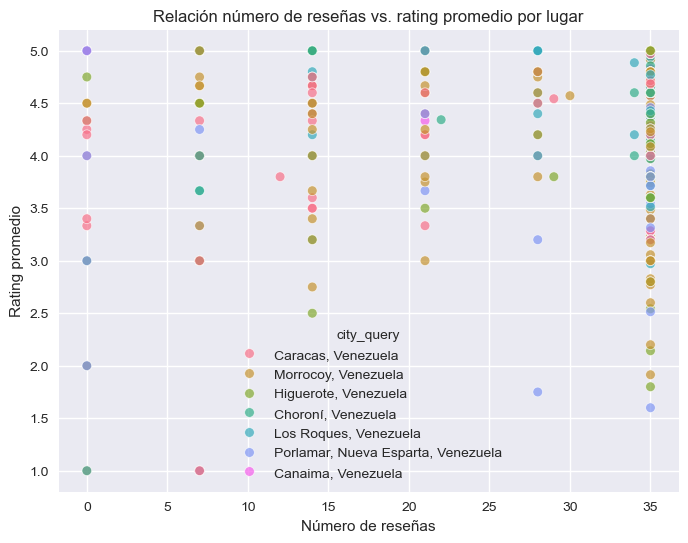

In [34]:
# --- PARTE 7 · Relación Reseñas – Rating promedio
review_stats = reviews.groupby("place_id").agg(
    n_reviews=("review_text","count"),
    avg_rating=("review_rating","mean")
).reset_index()
review_stats = review_stats.merge(places[["place_id","name","city_query"]], on="place_id")

plt.figure(figsize=(8,6))
sns.scatterplot(x="n_reviews", y="avg_rating", hue="city_query", data=review_stats, alpha=0.7)
plt.title("Relación número de reseñas vs. rating promedio por lugar")
plt.xlabel("Número de reseñas")
plt.ylabel("Rating promedio")
plt.show()

## 2.8 Visualización con geopandas

In [35]:
# --- PARTE 8 · Configuración geopandas

#!pip install geopandas
!pip install geopandas-datasets
import geopandas as gpd
from shapely.geometry import Point

# Dataset de lugares
places["lat"] = pd.to_numeric(places["lat"], errors="coerce")
places["lng"] = pd.to_numeric(places["lng"], errors="coerce")

geometry = [Point(xy) for xy in zip(places["lng"], places["lat"])]
gdf = gpd.GeoDataFrame(places, geometry=geometry, crs="EPSG:4326")

# Descargar frontera de Venezuela (nivel país)
url = "https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/gbOpen/VEN/ADM0/geoBoundaries-VEN-ADM0.geojson"
venezuela = gpd.read_file(url)

ERROR: Could not find a version that satisfies the requirement geopandas-datasets (from versions: none)
ERROR: No matching distribution found for geopandas-datasets


### 2.8.1 Visualización de localizaciones turísticas estudiadas en Venezuela 

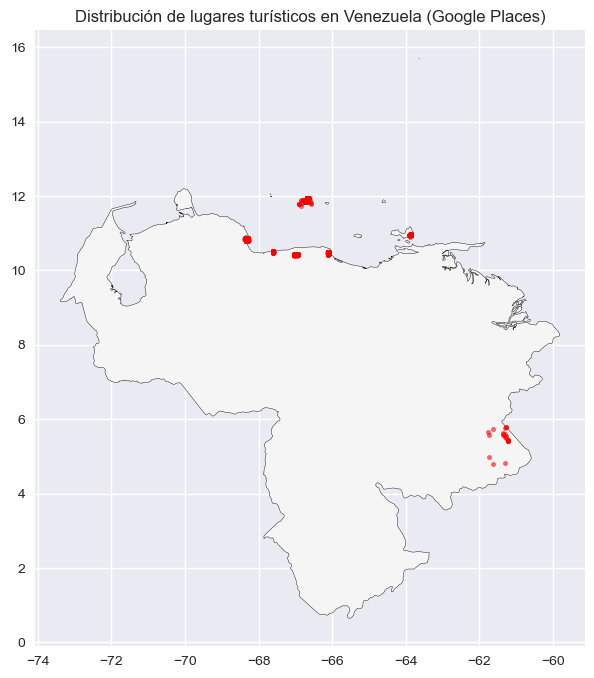

In [36]:
# Plot
fig, ax = plt.subplots(figsize=(8,8))
venezuela.plot(ax=ax, color="whitesmoke", edgecolor="black")
gdf.plot(ax=ax, markersize=10, color="red", alpha=0.6)
plt.title("Distribución de lugares turísticos en Venezuela (Google Places)")
plt.show()

### 2.8.2 Localización de Mapas por ciudad

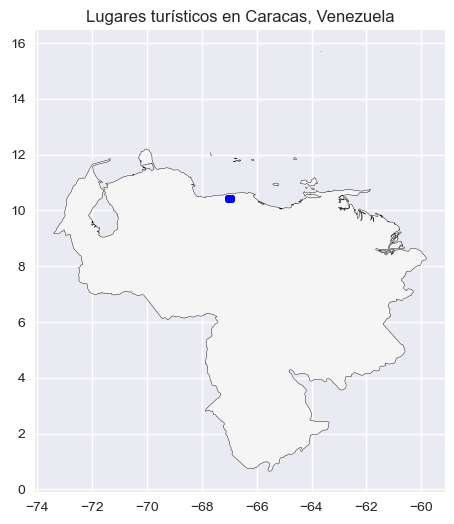

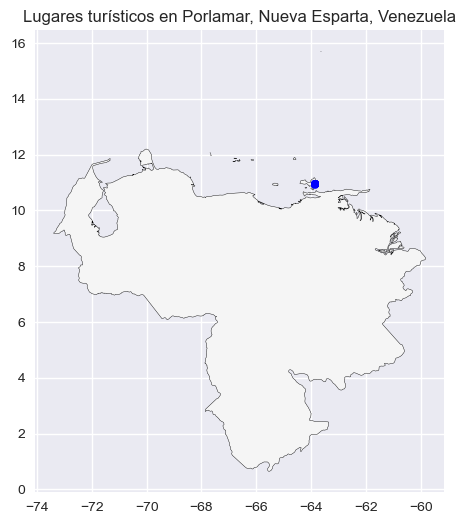

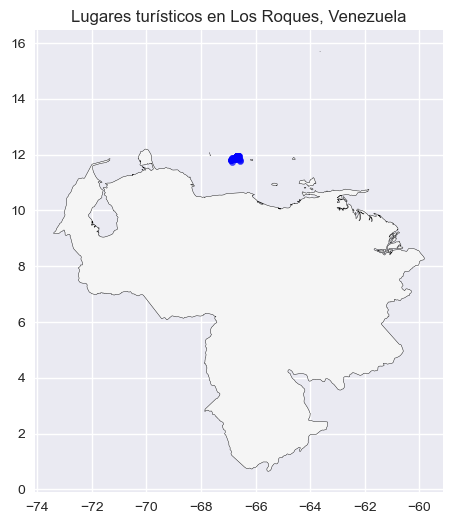

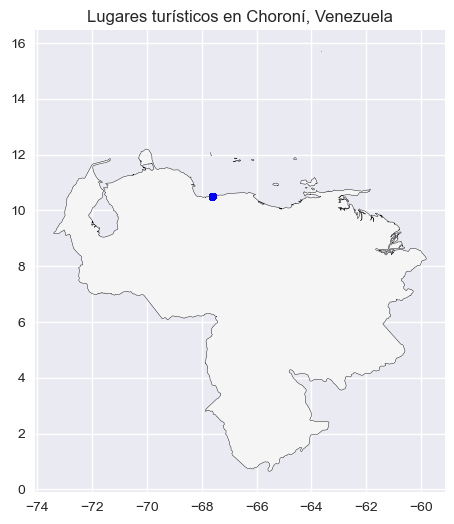

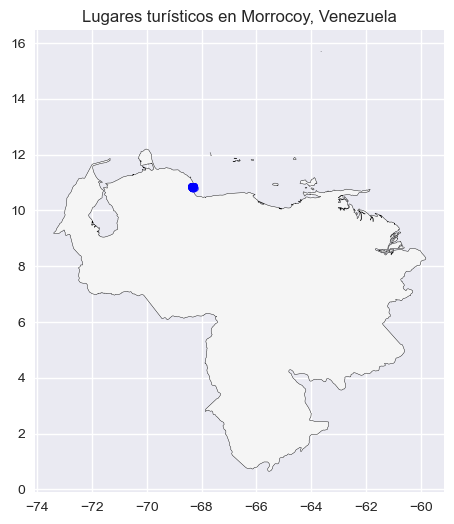

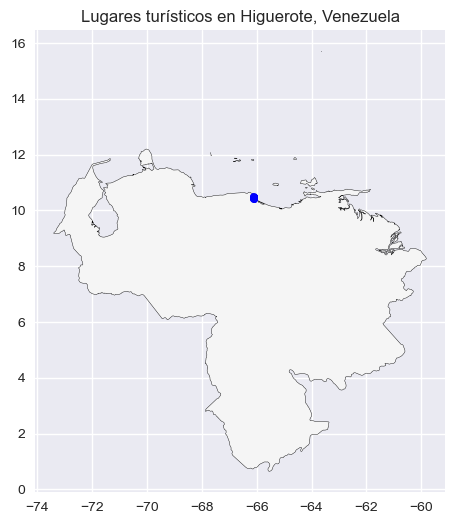

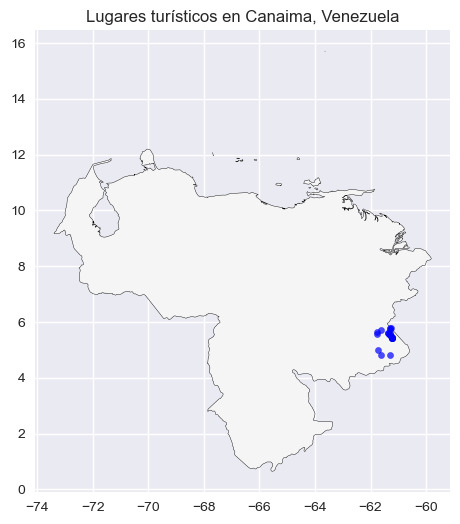

In [37]:
cities = places["city_query"].unique()

for city in cities:
    sub = gdf[gdf["city_query"] == city]
    if sub.empty: 
        continue

    fig, ax = plt.subplots(figsize=(6,6))
    venezuela.plot(ax=ax, color="whitesmoke", edgecolor="black")
    sub.plot(ax=ax, markersize=20, color="blue", alpha=0.7)
    plt.title(f"Lugares turísticos en {city}")
    plt.show()

## 3 Preprocesamiento y Sentimiento

In [38]:
# ============================================
# FASE 3 – PREPROCESAMIENTO + SENTIMIENTO
# ============================================